# Distinguishability

### What is photon distinguishability?

Ideal photonic quantum computing assumes that the photons are indistinguishable -- that they cannot be distinguished by ``internal'', or unobserved, degrees of freedom (such as frequency, bandwidth, polarization, spatial mode, and arrival time). In practice, this assumption is not met. Any imperfections in hardware will cause the internal states of photons to differ.

Photon indistinguishability is crucial because nearly all photonic quantum-processing schemes rely on multi-photon interference (for example, the famous Hong–Ou–Mandel effect). When two or more photons arrive at a beamsplitter in indistinguishable states, they “bunch” together (i.e., exit in the same mode) with high probability due to quantum interference. This is the basis for many gate implementations, such as controlled-NOT gates and other linear optical circuits used in boson sampling or other quantum protocols.

 Graphically, we can represent (and compute the effect of) the Hong-Ou-Mandel effect as follows:

 ![HOM](./hom.png "Hong-Ou-Mandel Effect")

#### How is photon distinguishability implemented in Optyx?

In optyx, we treat each bosonic wire as encoding a probability amplitude of an internal state of a photon.

When creating a photon we can give an internal state of some dimension *d*, which will be used to compare the degree of distinguishability between photons. Different photon creations within a diagram can have different internal states. 

The amplitudes and probabilities for circuits with internal states are computing by *inflating* the diagram by *d*.

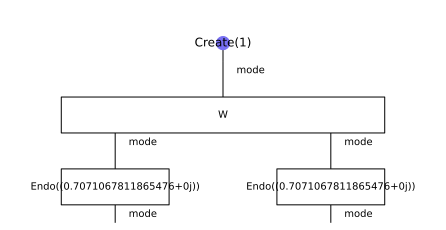

In [1]:
from optyx.core.zw import Create

state1 = [1, 0]
state2 = [0.5**0.5, 0.5**0.5]

Create(1, internal_states=(state2, )).inflate(2).foliation().draw(figsize=(6, 3))

Similarly, every DualRail box with an internal state can be inflated.

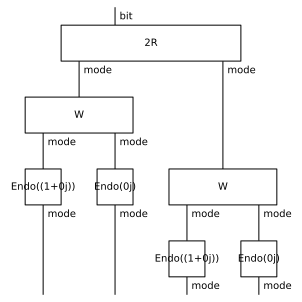

In [2]:
from optyx.core.diagram import DualRail

DualRail(internal_state=state1).inflate(2).foliation().draw()

### HOM with indistinguishable photons

We will show that if the photons are non-distinguishable, we obtain a perfect Hong-Ou-Mandel effect.

In [3]:
from optyx.photonic import Create, NumberResolvingMeasurement, BS

The states of two particles are the same:

In [4]:
internal_state_1 = [0.5**0.5, 0.5**0.5]
internal_state_2 = [0.5**0.5, 0.5**0.5]

In [5]:
channel_BS = (
    Create(1, 1, internal_states=(internal_state_1,
                                  internal_state_2)) >>
    BS >> NumberResolvingMeasurement(2)
).inflate(len(internal_state_1))

In [6]:
result = channel_BS.eval().prob_dist()

In [7]:
result

{(0, 2): (0.5+0j), (1, 1): (1.2325951644078304e-32+0j), (2, 0): (0.5+0j)}

This means that we cannot get a single photon at each output.

### HOM with distinguishable photons

Here, we define states which are different:

In [8]:
import numpy as np

In [9]:
internal_state_1 = np.random.rand(2) + 1j*np.random.rand(2)
internal_state_1 = internal_state_1 / np.linalg.norm(internal_state_1)
internal_state_2 = np.random.rand(2) + 1j*np.random.rand(2)
internal_state_2 = internal_state_2 / np.linalg.norm(internal_state_2)

In [10]:
internal_state_1

array([0.46805045+0.03203795j, 0.78186157+0.41060301j])

In [11]:
internal_state_2

array([0.54051796+0.56786515j, 0.46030203+0.41652317j])

In [12]:
channel_BS = (
    Create(1, 1, internal_states=(internal_state_1,
                                  internal_state_2)) >>
    BS >> NumberResolvingMeasurement(2)
).inflate(len(internal_state_1))

In [13]:
result = channel_BS.eval().prob_dist()

In [14]:
result

{(0, 2): (0.4479236685298761+1.66268625707414e-18j),
 (1, 1): (0.10415266294024787-1.7203160321962734e-17j),
 (2, 0): (0.4479236685298761+1.5540474064888597e-17j)}

This can be confirmed using the formula: $\frac{1}{2} - \frac{1}{2} \left| \langle \psi_0 | \psi_1 \rangle \right|^2$

In [15]:
0.5 - 0.5*np.abs(np.array(internal_state_1).dot(np.array(internal_state_2).conjugate()))**2

0.10415266294024783

### Fusion with distinguishable photons

We now define a fusion measurement and consider the influence of distinguishability in a fusion induced Bell pair.

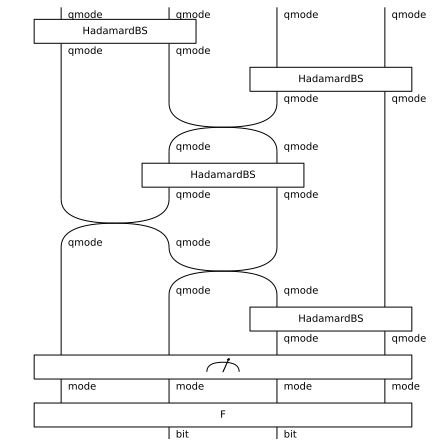

In [16]:
from optyx import qmode, mode, bit

from optyx.photonic import (
    DualRail,
    Swap,
    HadamardBS
)

fusion = (
    HadamardBS() @ HadamardBS() >>
    qmode @ Swap(1, 1) @ qmode >>
    qmode @ HadamardBS() @ qmode >>
    Swap(1, 1) @ qmode @ qmode >>
    qmode @ Swap(1, 1) @ qmode >>
    qmode @ qmode @ HadamardBS()
)

from optyx.classical import (
    ClassicalFunction
)
from optyx.core.diagram import Mode, Bit

def fusion_function(x):
    """
    A classical function that returns two bits based on an input x,
    based on the classical logical for the Fusion type II circuit.
    """
    a = x[0]
    b = x[1]
    c = x[2]
    d = x[3]
    s = (a % 2) ^ (b % 2)
    k = int(s*(b + d) + (1-s)*(1 - (a + b)/2))%2
    return [s, k]

classical_function = ClassicalFunction(
    fusion_function,
    mode**4,
    bit**2
)

fusion_channel = fusion >> NumberResolvingMeasurement(4) >> classical_function
fusion_channel.draw(figsize=(6, 6))

In [17]:
amp = 0.1
internal_state_1 = [1, 0]
internal_state_2 = [1, 0]
internal_state_2 = internal_state_2 / np.linalg.norm(internal_state_2)

print(internal_state_1, internal_state_2)

[1, 0] [1. 0.]


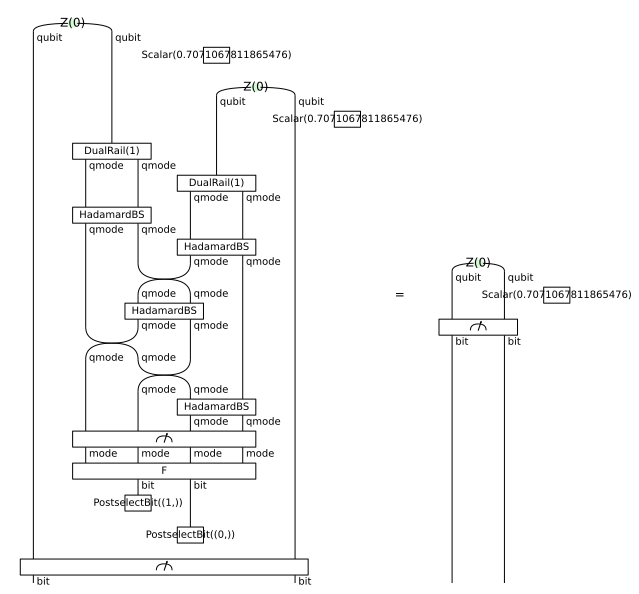

In [18]:
from optyx.qubits import Z, Scalar, Id, Measure
from optyx.photonic import DualRail
from optyx.classical import PostselectBit
from discopy.drawing import Equation
from optyx.core.channel import Diagram, bit, qubit, mode, qmode

bell_state = (Z(0, 2) @ Scalar(0.5 ** 0.5))
dual_rail_encoding = lambda state: DualRail(1, internal_states=[state])
post_select = PostselectBit(1) @ PostselectBit(0)

def fusion(internal_state_1, internal_state_2):
    @Diagram.from_callable(dom=bit ** 0, cod=qubit**2)
    def d():
        a = (bell_state @ bell_state)()
        b = (dual_rail_encoding(internal_state_1) @ dual_rail_encoding(internal_state_2))(a[1], a[2])
        c = fusion_channel(*b)
        post_select(c[0], c[1])
        return a[0], a[3]

    return d

@Diagram.from_callable(dom=bit ** 0, cod=qubit**2)
def bell():
    a1, a2 = bell_state()
    return a1, a2

Equation(fusion(internal_state_1, internal_state_2) >> Measure(2), bell >> Measure(2)).draw(figsize=(8, 8))

In [19]:
from optyx.qubits import Discard
(fusion(internal_state_1, internal_state_2) >> Discard(2)).inflate(2).eval().tensor.array

array(0.25-0.j)

In [20]:
fidelity = (fusion(internal_state_1, internal_state_2) >> bell_state.dagger())

normalisation = (fusion(internal_state_1, internal_state_2) >> Discard(2)).inflate(2).eval().tensor.array

In [21]:
f = fidelity.inflate(2).eval().tensor.array
f/normalisation

(1.0000000000000002-1.83697019872103e-16j)

In [22]:
import math

def rotated_unit_vectors(n: int = 10):
    for i in range(n):
        theta = i * (math.pi / 2) / (n - 1)
        yield (math.cos(theta), math.sin(theta))

In [23]:
unit_vectors = list(rotated_unit_vectors(30))

In [24]:
inner_product_states = []
inner_product_bell_states = []

result_bell = bell_state.eval().tensor.array.flatten()
result_bell = result_bell / np.linalg.norm(result_bell)

for vector in unit_vectors:
    encoding_layer =  dual_rail_encoding(internal_state_1) @ dual_rail_encoding(vector)
    experiment = bell_state @ bell_state >> Id(1) @ (encoding_layer >> fusion_channel
                                                                                >> post_select) @ Id(1)

    f = (experiment >> bell_state.dagger()).inflate(2).eval().tensor.array
    normalisation = (experiment >> Discard(2)).inflate(2).eval().tensor.array

    inner_product_states.append(np.inner(vector, internal_state_1))
    inner_product_bell_states.append(f/normalisation)

/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


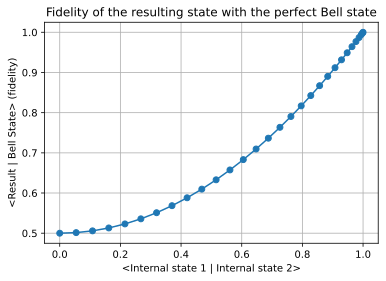

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(inner_product_states, inner_product_bell_states, marker='o')
plt.xlabel('<Internal state 1 | Internal state 2>')
plt.ylabel('<Result | Bell State> (fidelity)')
plt.title('Fidelity of the resulting state with the perfect Bell state')
plt.grid(True)
plt.show()

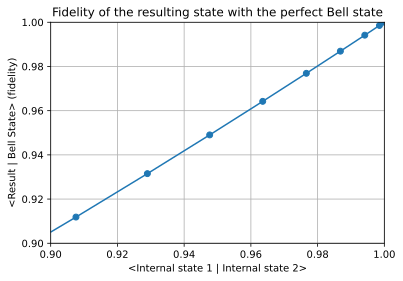

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(inner_product_states, inner_product_bell_states, marker='o')
plt.xlabel('<Internal state 1 | Internal state 2>')
plt.ylabel('<Result | Bell State> (fidelity)')
plt.title('Fidelity of the resulting state with the perfect Bell state')
plt.xlim(0.9, 1)
plt.ylim(0.9, 1)
plt.grid(True)
plt.show()